# Expectation Maximization for Exponential Distribution.

Note: Have patience. It will take time to run!!! Restart the kernel if it gets stuck.

In [11]:
import numpy as np
import pandas as pd
from scipy.special import gammaln
import matplotlib.pyplot as plt
import math
from scipy import stats
import seaborn as sns
from math import sqrt, log, exp, pi
from random import uniform


from distutils.version import StrictVersion
import scipy as sp
if StrictVersion(sp.__version__) >= StrictVersion("1.0.0"):
    from scipy.special import logsumexp
else:
    from scipy.misc import logsumexp

In [12]:
class EMM:
    """
    Exponential mixture model. EM algorithm is used for fitting.
    The EM algorithm is run several times to avoid local maxima
    as much as possible.
    Parameters
    ----------
    k : int, optional
        Number of components initially given.
    n_init : int, optional
        EM algorithm is run n_init times with different initial conditions.
        The estimated parameters that maximize the joint likelihood
        are selected.
    n_iter : int, optional
        Number of iterations in the EM algorithm.
    random_state : int, RandomState instance or None(default)
        Seed of random number generator.
    """

    def __init__(self, k=4, n_init=100, n_iter=30, random_state=None):
        self.k = k
        self.n_init = n_init
        self.n_iter = n_iter
        self.rnd = random_state if type(random_state) is np.random.RandomState else np.random.RandomState(random_state)

        # parameters
        self.pi = None  # mixing weight
        self.mu = None  # mean of the exponential distribution

        # latent variables
        self.z = None
        self.n_each_exp = None  # number of samples that belong to each component
        self.k_final = None  # effective number of components

        # data
        self.n = None  # length of data
        self.x = None  # values of data

        # empirical log likelihood
        self.marginal_log_likelihood = None  # empirical marginal log likelihood
        self.it = None

    def fit(self, x1):
        """
        Fit an EMM to data 'x'.
        Parameters
        ----------
        x : list or array
            Data.
        Returns
        -------
        pi : array
            Mixing weight of the individual exponential distribution in
            the estimated EMM. The array length is k_final.
        mu : array
            Mean parameter of the individual exponential distribution in
            the estimated EMM. The array length is k_final.
        """
        x1 = np.array(x1)
        if 0 in x1:
            self.x = x1[x1 > 0]
            print("'x1' contains 0, which has been removed.")
        else:
            self.x = x1
        self.n = len(self.x)

        max_log_likelihood = - np.inf
        for i in range(self.n_init):
            # generate initial mu randomly
            mu0 = 10 ** self.rnd.uniform(np.log10(min(self.x)), np.log10(max(self.x)), self.k)

            z, temp_marginal_log_likelihood = _run_em(self.x, self.k, n_iter=self.n_iter, mu0=mu0)
            self.it = np.append(self.it, i)
            temp_results = _calc_joint_mle(self.x, z)

            # use the estimated parameter set that maximizes joint log likelihood
            if temp_results[-1] > max_log_likelihood:
                max_log_likelihood = temp_results[-1]
                self.marginal_log_likelihood = temp_marginal_log_likelihood
                self.pi, self.mu, self.z, self.n_each_exp, self.k_final = temp_results

        return self.pi, self.mu

    def exponential_pdf(self, x, pi, mu):
        """
        Probability density function value, p(x), at each element,
        x_i, of x.
        Parameters
        ----------
        x : float or array
            Data.
        Returns
        -------
        y: float or array
            Value of p(x).
        """
        #self._check_fitted()
        try:
            y = np.zeros(len(x))
        except TypeError:
            # x is not array
            y = 0
        
        pi_j = pi
        mu_j = mu
        print("pi_j, mu_j", pi_j, mu_j)
        y = pi_j / mu_j * np.exp(- x / mu_j)
        return y

    def print_result(self):
        """
        Print parameters and k_final of the estimated EMM.
        """
        self._check_fitted()
        head = "------- EMM(k=%d, k_final=%d) -------" % (self.k, self.k_final)
        print(head)
        for j in range(self.k_final):
            print("component %d: (pi, mu)=(%0.3f, %0.3f)" % (j+1, self.pi[j], self.mu[j]))
        print("-" * len(head))

    def _check_fitted(self):
        """
        Check if this instance is fitted.
        """
        if self.k_final is None:
            raise AttributeError("This EMM instance is not fitted yet. Call 'fit' or 'generate' beforehand.")


In [13]:
def _calc_joint_mle(x, z):
    """
    Calculate the maximum likelihood estimators of EMM whose latent
    variables completed.
    Parameters
    ----------
    x : array
        Data.
    z : array
        Estimated latent variables.
    Returns
    ----------
    pi : array
        Mixing weight of the individual exponential distribution in the EMM.
        The length of the array = k_final.
    mu : array
        Mean of the individual exponential distribution in the EMM.
        The length of the array = k_final. Sorted in ascending order.
    z : array
        Latent variables whose labels are swapped.
    n_each_exp : array
        Number of samples that belong to each component.
    k_final : int
        Number of components that are used at least once under the estimated
        latent variable values.
    """
    n = len(x)  # length of data

    counts = np.bincount(z)
    z = (np.cumsum(counts > 0) - 1)[z]
    n_each_exp = counts[counts > 0]  # number of samples that belong to each component
    k_final = len(n_each_exp)  # effective number of components
    #enable it if you need prints
    #print("***************************************************************************************")
    #print("k_final=",k_final)

    pi = n_each_exp / float(n)
    mu = np.dot(np.eye(k_final)[z].T, x) / n_each_exp

    # sort components' indices in ascending order of mu
    mu_ascend = np.argsort(mu)
    z = mu_ascend[z]
    n_each_exp = n_each_exp[mu_ascend]
    pi = pi[mu_ascend]
    mu = mu[mu_ascend]
    
    return pi, mu, z, n_each_exp, k_final



def _run_em(x, k, mu0=None, n_iter=1000):
    """
    Fit EMM to data 'x' by the EM algorithm.
    Parameters
    ----------
    x : array
        Data.
    k : int
        Number of components.
    mu0 : array, optional
        Initial values of mu.
    n_iter : int, optional
        Number of iterations in the EM algorithm.
    Returns
    ----------
    z : array
        Estimated latent variables.
    marginal_log_likelihood : float
        Empirical marginal log likelihood.
    """
    if mu0 is None:
        mu0 = np.logspace(np.log10(min(x)), np.log10(max(x)), k)
    n = len(x)
    pi = np.ones(k) / k
    mu = np.array(mu0)
    log_pi = np.log(pi)
    log_mu = np.log(mu)
    log_x = np.log(x[:, np.newaxis])
    
    log_likelihood = []
    for i in range(n_iter):
        # E step
        log_gamma = log_pi[np.newaxis, :] - log_mu[np.newaxis, :] - x[:, np.newaxis] / np.exp(log_mu)[np.newaxis, :]
        log_gamma = log_gamma - logsumexp(log_gamma, axis=1, keepdims=True)

        # M step
        log_pi = logsumexp(log_gamma, axis=0) - np.log(n)
        log_mu = logsumexp(log_gamma + log_x, axis=0) - logsumexp(log_gamma, axis=0)
        #Calculate the log likelihood for each iteration with new mu and pi
        m = _marginal_log_likelihood(x, np.exp(log_pi), np.exp(log_mu))
        #store it in a array
        log_likelihood.append(m)
        
    #plot log likelihood    
    length = len(log_likelihood)
    arr = np.array(log_likelihood)
    #uncomment below line, if you need individual graph
    #plt.figure(figsize = (10,7))
    plt.plot(range(length), arr)
    plt.title("Log Likelihood Graph:")
    plt.xlabel("X axis: No of iterations")
    plt.ylabel("Y axis: Log likelihood")

    # estimate z
    log_gamma = log_pi[np.newaxis, :] - log_mu[np.newaxis, :] - x[:, np.newaxis] / np.exp(log_mu)[np.newaxis, :]
    z = np.argmax(log_gamma, axis=1).astype('int32')

    marginal_log_likelihood = _marginal_log_likelihood(x, np.exp(log_pi), np.exp(log_mu))

    return z, marginal_log_likelihood


def _marginal_log_likelihood(x, pi, mu):
    """
    Calculate the logarithm of the marginal likelihood.
    Parameters
    ----------
    x : array
        Data.
    pi : array
        Mixing weight of the individual component in the estimated EMM.
    mu : array
        Mean of the individual exponential distribution in the estimated EMM.
    """
    log_gamma = np.log(pi[np.newaxis, :]) - np.log(mu[np.newaxis, :]) - x[:, np.newaxis] / mu[np.newaxis, :]
    each_log_likelihood = logsumexp(log_gamma, axis=1)
    return np.sum(each_log_likelihood)

mu [7.92690651 6.90655329 7.36363962 8.3332114 ]
pi_j, mu_j 0.25 7.9269065064
pi_j, mu_j 0.25 6.906553287200001
pi_j, mu_j 0.25 7.363639616672002
pi_j, mu_j 0.25 8.333211398960005

------- EMM(k=4, k_final=4) -------
component 1: (pi, mu)=(0.001, 0.000)
component 2: (pi, mu)=(0.002, 0.000)
component 3: (pi, mu)=(0.659, 0.979)
component 4: (pi, mu)=(0.338, 20.674)
-----------------------------------


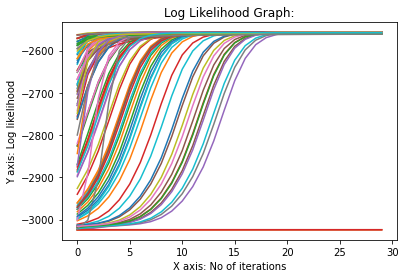

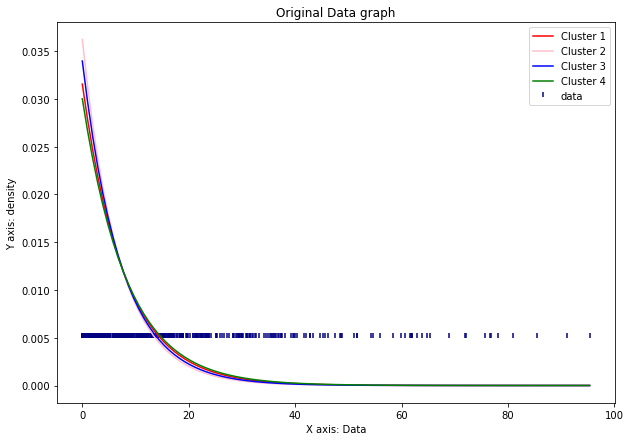

In [14]:
col_names=['x']
df = pd.read_csv("A2Q1.csv",names=col_names)
df.head(n=5)

#show the distribution of the data as a histogram
data = df.x
model = EMM()

#Step-1. Axis 0 indicates add the columns to calulate mean
mu1 =  np.mean(data[:250] , axis = 0)
mu2 =  np.mean(data[250:500] , axis = 0)
mu3 =  np.mean(data[500:750] , axis = 0)
mu4 =  np.mean(data[750:1000] , axis = 0)

_pi = [0.25, 0.25, 0.25, 0.25]

#program starts mainly here!
pi, mu = model.fit(data)

# visualize the training data
bins = np.linspace(np.min(data), np.max(data), 100)

plt.figure(figsize = (10,7))
plt.xlabel("X axis: Data")
plt.ylabel("Y axis: density")
plt.title("Original Data graph")
plt.scatter(data, [0.005] * len(data), color='navy', s=30, marker=2, label="data")



#plot the gaussian curve
#_pi = model.pi
_mu = []
_mu = np.append(_mu, mu1)
_mu = np.append(_mu, mu2)
_mu = np.append(_mu, mu3)
_mu = np.append(_mu, mu4)

print("mu", _mu)
z = model.exponential_pdf(bins, 0.25, mu1)
plt.plot(bins, z, color='red', label = 'Cluster 1')
z = model.exponential_pdf(bins, 0.25, mu2)
plt.plot(bins, z, color='pink', label = 'Cluster 2')
z = model.exponential_pdf(bins, 0.25, mu3)
plt.plot(bins, z, color='blue', label = 'Cluster 3')
z = model.exponential_pdf(bins, 0.25, mu4)
plt.plot(bins, z, color='green', label = 'Cluster 4')

plt.legend()
plt.plot()

  # estimate the parameters
print()
model.print_result()  # print 'k_final' (i.e., the estimated effective number of components) and the estimated parameters

model.pi  model.mu [0.001 0.002 0.659 0.338] [1.64280000e-05 2.88390000e-04 9.78620196e-01 2.06735692e+01]
pi_j, mu_j 0.001 1.6428e-05
pi_j, mu_j 0.002 0.00028839
pi_j, mu_j 0.659 0.978620195902883
pi_j, mu_j 0.338 20.673569230769235


[]

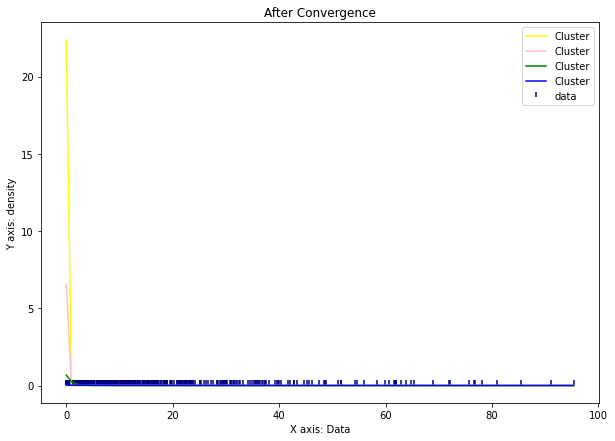

In [15]:
# visualize the training data
bins = np.linspace(np.min(data), np.max(data), 100)

plt.figure(figsize = (10,7))
plt.title("After Convergence")
plt.xlabel("X axis: Data")
plt.ylabel("Y axis: density")
plt.scatter(data, [0.005] * len(data), color='navy', s=30, marker=2, label="data")

colors = ['yellow' , 'pink', 'green', 'blue']
i = 0
print("model.pi  model.mu", model.pi, model.mu)
for pi_j, mu_j in zip(model.pi, model.mu): 
    z = model.exponential_pdf(bins, pi_j, mu_j)
    plt.plot(bins, z, color=colors[i], label = 'Cluster')
    i = i+1

plt.legend()
plt.plot()